# set up

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Imports

import os
from PIL import Image
import random
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import math

from visualization_new import *

import wave
import librosa
from unidecode import unidecode
import csv

# image prep

In [24]:
def get_genres(folderpath):
    genre_id = {}

    for genre in os.listdir(folderpath):
        i = 1
        while (genre[:i] in genre_id.values() and i <= len(genre)):
            i += 1
        genre_id[genre] = genre[:i]
    
    return genre_id


In [25]:
# audio dict (initial)
def get_audio_dict(audio_folderpath, genre_id):
    audio_dict = {}

    for genre in genre_id:
        files = os.listdir(os.path.join(audio_folderpath, genre))
        count = 0
        # TODO: given an audio dictionary, find what max count for a genre is
        for file in files:
            filepath = os.path.join(audio_folderpath, genre, file)
            id = genre_id[genre] + '{:03d}'.format(count)
            count += 1
            audio_dict[id] = filepath
    
    return audio_dict

def create_csv(csv_filepath, audio_dict):
    with open(csv_filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(list(audio_dict.items()))


# audio dict (after initial)
def get_audio_dict_csv(csv_filepath):
    with open(csv_filepath, 'r') as file:
        reader = csv.reader(file)
        #next(reader)
        audio_dict = {row[0]: row[1] for row in reader}
    
    return audio_dict

In [26]:
def split_train_test(id_list, ratio):
    random.shuffle(id_list)
    split_index = int(ratio * len(id_list))

    train_set = id_list[:split_index]
    test_set = id_list[split_index:]

    return train_set, test_set

def split_k_fold(id_list, n_batches):
    random.shuffle(id_list)
    batches = []
    index = 0
    batch_size = math.ceil(len(id_list)/n_batches)
    
    for i in range(n_batches - 1):
        batches.append(id_list[index:index+batch_size])
        index += batch_size
    batches.append(id_list[index:len(id_list)-1])

    return batches


In [27]:
def get_image_func(image_type):
    if image_type == "spectrogram":
        return wav_to_spectrogram
    elif image_type == "chromagram":
        return wav_to_chromagram
    elif image_type == "mfcc":
        return wav_to_mfcc
    elif image_type == "cochleagram":
        return wav_to_cochleagram
    else:
        return
    


In [28]:
# Set constants

# Paths
dataset = "large"
if dataset == "small":
    audio_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/audio/small"
    image_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/images/small"
    csv_filepath = "C:/Users/anany/Cambridge/Part II Project/data/small.csv"
if dataset == "large":
    audio_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/audio/large"
    image_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/images/large"
    csv_filepath = "C:/Users/anany/Cambridge/Part II Project/data/large.csv"

image_type = "spectrogram"
to_image = get_image_func(image_type)

# Image options
clip_length = 10
shift_length = 5
resize_dim = 129
save = False

# Model parameters
generate = True
split_ratio = 0.8
k_folds = 5 # Only relevant if cross_validation is True
cross_validation = False
epochs = 15
gen_batch_size = 5 # Only relevant if generate is True
model_batch_size = 32

In [29]:
def get_labels(id_list, label_list):
    labels = np.array([label_list.index(x[0]) for x in id_list])
    labels = labels.reshape((len(labels), 1))
    return labels

In [30]:
def image_split_label(id, audio_dict, clip_length, shift_length, resize_dim, label_list, folderpath = None):
    '''
    If folderpath is None, convert the audio file. If a folderpath is provided, obtain the images from this path.
    Returns
    -------
    ids: list
    imgs: numpy array
    labels: numpy array
    '''
    ids = []
    imgs = None
    labels = None

    # CONVERT/GET
    if folderpath == None:
        filepath = audio_dict[id]
        images = to_image(filepath)

    # SPLIT
    for i in range(2):
        if folderpath == None:
            img = images[i]
        else:
            filepath = os.path.join(folderpath, f"{id}_ch{i}.png")
            assert(os.path.exists(filepath))
            img = Image.open(filepath)
        img_dict = split(img, id + "_ch" + str(i), clip_length, shift_length, resize_dim)
        
        # Set/update audio sample id list
        ids.extend(list(img_dict.keys()))

        # Set/update array of image arrays
        if imgs is None:
            imgs = np.array(list(img_dict.values()))
        else:
            imgs = np.append(imgs, np.array(list(img_dict.values())), axis = 0)

    # LABEL
    labels = get_labels(ids, label_list=label_list)

    return ids, imgs, labels

    

In [32]:
def special_character_check(audio_folderpath):
    for genre in os.listdir(audio_folderpath):
        files = os.listdir(os.path.join(audio_folderpath, genre))
        for file in files:
            if file != unidecode(file):
                filepath = os.path.join(audio_folderpath, genre, file)
                if unidecode(filepath) != filepath:
                    print(filepath)

# WITHOUT GENERATOR

In [37]:
def convert_and_save(id_list, audio_dict, folderpath):
    count = 0
    for id in id_list:
    # CONVERT
        count += 1
        print(f"{count}/{len(id_list)}    {id}", end="")
        filepath = audio_dict[id]
        images = to_image(filepath)

        # SAVE
        for i in range(2):
            images[i].save(os.path.join(folderpath, f"{id}_ch{i}.png"))
        print("   DONE")

In [38]:
def return_data(id_list, audio_dict, clip_length, shift_length, resize_dim, label_list, folderpath=None):
    ids = None
    imgs = None
    labels = None


    count = 0
    for id in id_list:

        # Convert to images, split, and get labels
        split_ids, split_imgs, split_labels = image_split_label(id, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=folderpath)
        
        # Set/update audio sample id list
        if ids is None:
            ids = split_ids
        else:
            ids = np.append(ids, split_ids, axis = 0)

        # Set/update array of image arrays
        if imgs is None:
            imgs = np.array(split_imgs)
        else:
            imgs = np.append(imgs, split_imgs, axis = 0)

        # Set/update array of image labels
        if labels is None:
            labels = split_labels
        else:
            labels = np.append(labels, split_labels, axis = 0)

        count += 1
    
    # Shuffle
    indices = random.sample(range(len(ids)), len(ids))
    ids = ids[indices]
    imgs = imgs[indices]
    labels = labels[indices]
    
    return ids, imgs, labels

In [39]:
def createModel(input_shape, type=1):
    if type == 1:
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))

        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(5))
    
    return model

'''def createModel2():
    model = models.Sequential()
    # The first two layers with 32 filters of window size 3x3
    #model.add(models.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train[0].shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_train[0].shape))
    
    model.add(models.Conv2D(32, (3, 3), activation='relu'))
    model.add(models.MaxPooling2D(pool_size=(2, 2)))
    model.add(models.Dropout(0.25))

    model.add(models.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(models.Conv2D(64, (3, 3), activation='relu'))
    model.add(models.MaxPooling2D(pool_size=(2, 2)))
    model.add(models.Dropout(0.25))

    model.add(models.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(models.models.Conv2D(64, (3, 3), activation='relu'))
    model.add(models.MaxPooling2D(pool_size=(2, 2)))
    model.add(models.Dropout(0.25))

    model.add(models.Flatten())
    model.add(models.Dense(512, activation='relu'))
    model.add(models.Dropout(0.5))
    model.add(models.Dense(models.nClasses, activation='softmax'))
    
    return model'''

"def createModel2():\n    model = models.Sequential()\n    # The first two layers with 32 filters of window size 3x3\n    #model.add(models.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train[0].shape))\n    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_train[0].shape))\n    \n    model.add(models.Conv2D(32, (3, 3), activation='relu'))\n    model.add(models.MaxPooling2D(pool_size=(2, 2)))\n    model.add(models.Dropout(0.25))\n\n    model.add(models.Conv2D(64, (3, 3), padding='same', activation='relu'))\n    model.add(models.Conv2D(64, (3, 3), activation='relu'))\n    model.add(models.MaxPooling2D(pool_size=(2, 2)))\n    model.add(models.Dropout(0.25))\n\n    model.add(models.Conv2D(64, (3, 3), padding='same', activation='relu'))\n    model.add(models.models.Conv2D(64, (3, 3), activation='relu'))\n    model.add(models.MaxPooling2D(pool_size=(2, 2)))\n    model.add(models.Dropout(0.25))\n\n    model.add(models.Flatten())\n    model.add(models.

In [40]:
genre_id = get_genres(audio_folderpath)
genre_list = list(genre_id.keys())
label_list = [genre_id[genre] for genre in genre_list]


In [41]:
if save:
    audio_dict = get_audio_dict(audio_folderpath, genre_id) # TODO: CHANGE TO MAKE??
    id_list = list(audio_dict.keys())
    convert_and_save(id_list, audio_dict=audio_dict, folderpath=image_folderpath)
    create_csv(csv_filepath=csv_filepath, audio_dict=audio_dict)

else:
    audio_dict = get_audio_dict_csv(csv_filepath=csv_filepath)
    id_list = list(audio_dict.keys())

1/950    b000   DONE
2/950    b001   DONE
3/950    b002   DONE
4/950    b003   DONE
5/950    b004   DONE
6/950    b005   DONE
7/950    b006   DONE
8/950    b007   DONE
9/950    b008   DONE
10/950    b009   DONE
11/950    b010   DONE
12/950    b011   DONE
13/950    b012   DONE
14/950    b013   DONE
15/950    b014   DONE
16/950    b015   DONE
17/950    b016   DONE
18/950    b017   DONE
19/950    b018   DONE
20/950    b019   DONE
21/950    b020   DONE
22/950    b021   DONE
23/950    b022   DONE
24/950    b023   DONE
25/950    b024   DONE
26/950    b025   DONE
27/950    b026   DONE
28/950    b027   DONE
29/950    b028   DONE
30/950    b029   DONE
31/950    b030   DONE
32/950    b031   DONE
33/950    b032   DONE
34/950    b033   DONE
35/950    b034   DONE
36/950    b035   DONE
37/950    b036   DONE
38/950    b037   DONE
39/950    b038   DONE
40/950    b039   DONE
41/950    b040   DONE
42/950    b041   DONE
43/950    b042   DONE
44/950    b043   DONE
45/950    b044   DONE
46/950    b045   DO

In [14]:
if not cross_validation and not generate:
    train_id_list, test_id_list = split_train_test(id_list=id_list, ratio=split_ratio)
    train_ids, x_train, y_train = return_data(train_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath)
    test_ids, x_test, y_test = return_data(test_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath)

    model = createModel(type=1, input_shape=x_train[0].shape)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=epochs, 
                        validation_data=(x_test, y_test))

    test_similarity = np.zeros((len(label_list), len(label_list)))

    test_pred_probs = model.predict(x_test)
    test_pred_classes = test_pred_probs.argmax(axis=1)
    test_actual = y_test.T[0]
    for i in range(len(test_pred_classes)):
        test_similarity[test_pred_classes[i]][test_actual[i]] += 1
    for i in range(len(label_list)):
        test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])


In [15]:
if cross_validation and not generate:
    train_val_id_list, test_id_list = split_train_test(id_list, split_ratio)
    batches = split_k_fold(train_val_id_list, k_folds)

    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []
    val_similarity = np.zeros((len(label_list), len(label_list)))
    test_similarity = np.zeros((len(label_list), len(label_list)))
    test_ids, x_test, y_test = return_data(test_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath)


    for b in range(len(batches)):

        # Get data
        if b != len(batches) - 1:
            train_id_list = batches[0:b] + batches[b+1:]
        else:
            train_id_list = batches[:-1]
        
        train_id_list = [item for batch in train_id_list for item in batch]
        val_id_list = batches[b]

        train_ids, x_train, y_train = return_data(train_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath)
        val_ids, x_val, y_val = return_data(val_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath)


        # Create model
        model = createModel(type=1, input_shape=x_train[0].shape)

        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
        
        # Train model
        history = model.fit(x_train, y_train, epochs=epochs, 
                            validation_data=(x_val, y_val))
        
        # Get results
        loss.append(np.array(history.history['loss']))
        accuracy.append(np.array(history.history['accuracy']))
        val_loss.append(np.array(history.history['val_loss']))
        val_accuracy.append(np.array(history.history['val_accuracy']))

        # Validation classification results
        val_pred_probs = model.predict(x_val)
        val_pred_classes = val_pred_probs.argmax(axis=1)
        val_actual = y_val.T[0]
        for i in range(len(val_pred_classes)):
            val_similarity[val_pred_classes[i]][val_actual[i]] += 1

        # Test classification results
        test_pred_probs = model.predict(x_test)
        test_pred_classes = test_pred_probs.argmax(axis=1)
        test_actual = y_test.T[0]
        for i in range(len(test_pred_classes)):
            test_similarity[test_pred_classes[i]][test_actual[i]] += 1

    loss = np.array(loss)
    accuracy = np.array(accuracy)
    val_loss = np.array(val_loss)
    val_accuracy = np.array(val_accuracy)

    for i in range(len(label_list)):
        val_similarity[:, i] = val_similarity[:, i]/sum(val_similarity[:, i])
        test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])

## graphs

In [16]:
if not cross_validation and not generate:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
if not cross_validation and not generate:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
if cross_validation and not generate:
    plt.plot(sum(loss)/len(loss), label='Average Training Loss')
    plt.plot(sum(val_loss)/len(loss), label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [19]:
if cross_validation and not generate:
    plt.plot(sum(accuracy)/len(accuracy), label='Average Training Accuracy')
    plt.plot(sum(val_accuracy)/len(val_accuracy), label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [20]:
if cross_validation and not generate:

    for i in range(len(label_list)):
        val_similarity[:, i] = val_similarity[:, i]/sum(val_similarity[:, i])

    fig, ax = plt.subplots()
    ax.imshow(val_similarity, cmap = "gray_r")

    labels = [item.get_text() for item in ax.get_yticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = genre_list[i - 1]

    ax.set_xticklabels(labels, rotation = 45, ha = "right")
    ax.set_yticklabels(labels)

    ax.set_xlabel("Actual class")
    ax.set_ylabel("Predicted class")
    ax.set_title("Validation Classification Matrix")

    plt.show()


In [21]:
if not generate:
    for i in range(len(label_list)):
        test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])

    fig, ax = plt.subplots()
    ax.imshow(test_similarity, cmap = "gray_r")

    labels = [item.get_text() for item in ax.get_yticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = genre_list[i - 1]

    ax.set_xticklabels(labels, rotation = 45, ha = "right")
    ax.set_yticklabels(labels)

    ax.set_xlabel("Actual class")
    ax.set_ylabel("Predicted class")
    ax.set_title("Test Classification Matrix")

    plt.show()

# WITH GEN

In [24]:
def generate_data(id_list, audio_dict, clip_length, shift_length, resize_dim, label_list, folderpath = None, gen_batch_size = 1, model_batch_size = None, mode = "train"):
    '''
    Parameters
    ----------
    id_list
        List of song IDs to be converted into images

    folderpath
        Path sa
    
    n
        Number of songs to convert each iteration
    
    mode
        "generate" or "return"

    Returns
    -------
    imgs
        Arrays of converted images

    labels
        Respective labels for converted images in imgs

    '''
    out_ids = []
    out_imgs = None
    out_labels = None
    n_count = 0
    id_count = 0

    if mode == "train":
    
        while True:
                
            '''
            # convert 1 song
            # update out_... values
            # update bigcount and smallcount
            # if smallcount mod n is 0:
                # shuffle all 3
                # update appropriate id list
                # yield id and label values
                # set everything to none
            
            # if bigcount == len(idlist):
                # count = 0
                # shuffle list?
            '''

            # convert 1 song
            id = id_list[id_count]
            #print(id_count, id)
            
            new_ids, new_imgs, new_labels = image_split_label(id, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=folderpath)

            out_ids.extend(new_ids)

            if out_imgs is None:
                out_imgs = new_imgs
                out_labels = new_labels
            else:
                out_imgs = np.append(out_imgs, new_imgs, axis=0)
                out_labels = np.append(out_labels, new_labels, axis=0)

            # update bigcount and smallcount
            n_count += 1
            id_count += 1

            if n_count % gen_batch_size == 0:
                assert(len(out_ids) == len(out_imgs) == len(out_labels)) # sanity check
                perm = np.random.permutation(len(out_ids))
                out_imgs = out_imgs[perm]
                out_labels = out_labels[perm]
                if model_batch_size is None:
                    yield out_imgs, out_labels
                else:
                    while len(out_labels) >= model_batch_size:
                        yield out_imgs[:model_batch_size], out_labels[:model_batch_size]
                        out_imgs = out_imgs[model_batch_size:]
                        out_labels = out_labels[model_batch_size:]

                out_ids = []
                out_imgs = None
                out_labels = None
            
            if id_count == len(id_list):
                id_count = 0
                random.shuffle(id_list)

    if mode == "test":
        # TODO return just images without shuffling
        while id_count < len(id_list):
            # convert 1 song
            id = id_list[id_count]
            print(id_count, id)
            
            new_ids, new_imgs, new_labels = image_split_label(id, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=folderpath)

            if out_imgs is None:
                out_imgs = new_imgs
            else:
                out_imgs = np.append(out_imgs, new_imgs, axis=0)

            n_count += 1
            id_count += 1

            if n_count % gen_batch_size == 0:
                yield out_imgs

                out_imgs = None                
            
            if id_count == len(id_list):
                if out_imgs is not None:
                    yield out_imgs
    

In [25]:
def get_clip_ids(id_list, audio_dict, clip_length, shift_length):
    clip_id_list = []
    for id in id_list:
        filepath = audio_dict[id]
        new_ids = []
        with wave.open(filepath, "rb") as wav_file:
            frame_count = wav_file.getnframes()
            sample_rate = wav_file.getframerate()

            audio_len = frame_count/sample_rate
        for i in range(2):
            left = 0.
            right = left + clip_length
            while right <= audio_len:
                new_id = f"{id}_ch{i}_{left}_{right}"
                new_ids.append(new_id)
                left += shift_length
                right += shift_length
        clip_id_list = clip_id_list + new_ids
    
    return clip_id_list


In [26]:
id_list_temp = []

for filename in os.listdir(image_folderpath):
    if filename[:4] not in id_list_temp:
        id_list_temp.append(filename[:4])

In [27]:
cross_validation = False
generate = True

In [28]:
if not cross_validation and generate:       # setup train/test, 

    train_id_list, val_id_list = split_train_test(id_list=id_list_temp, ratio=split_ratio)

    train_set_len = len(get_clip_ids(train_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length))
    val_set_len = len(get_clip_ids(val_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length))


    train_func = generate_data(train_id_list, folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="train", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
    val_func = generate_data(val_id_list, folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="train", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
    
    input_shape = (resize_dim, resize_dim, 1)

    model_gen = createModel(input_shape=input_shape)
    # TODO: what if not resized -- how to get dimensions of an 

    model_gen.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    history_gen = model_gen.fit(train_func,
                        steps_per_epoch=int(train_set_len/model_batch_size),
                                epochs=3,
                                validation_data=val_func,
                                validation_steps=int(val_set_len/model_batch_size),
                                shuffle=True,
                                batch_size=model_batch_size)

Epoch 1/3
2/2 [==============================] - 3s 2s/step - loss: 1.5855 - accuracy: 1.0000 - val_loss: 1.5768 - val_accuracy: 1.0000
Epoch 2/3
2/2 [==============================] - 1s 884ms/step - loss: 1.5674 - accuracy: 1.0000 - val_loss: 1.5599 - val_accuracy: 1.0000
Epoch 3/3
2/2 [==============================] - 1s 841ms/step - loss: 1.5496 - accuracy: 1.0000 - val_loss: 1.5428 - val_accuracy: 1.0000


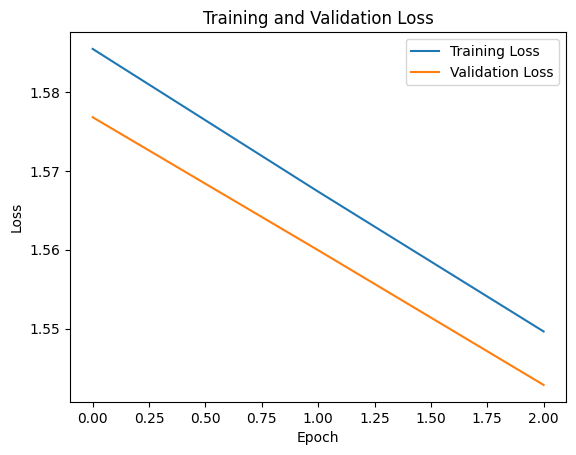

In [29]:
if not cross_validation and generate:
    plt.plot(history_gen.history['loss'], label='Training Loss')
    plt.plot(history_gen.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

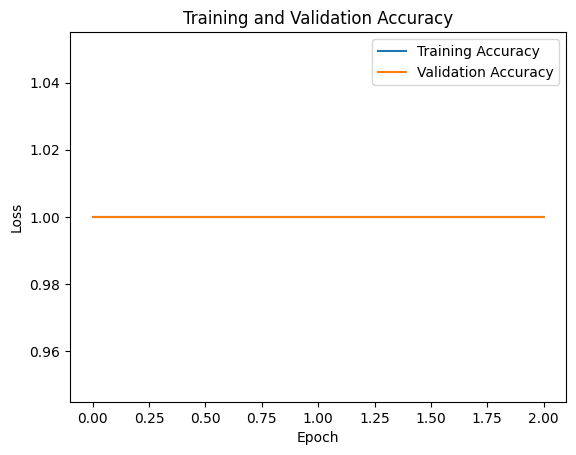

In [30]:
if not cross_validation and generate:
    plt.plot(history_gen.history['accuracy'], label='Training Accuracy')
    plt.plot(history_gen.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [35]:
test_similarity = np.zeros((len(label_list), len(label_list)))

test_pred_probs = model_gen.predict(generate_data(val_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath, gen_batch_size=5, mode="test"))
test_pred_classes = test_pred_probs.argmax(axis=1)
test_actual = get_labels(get_clip_ids(val_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length), label_list=label_list)
for i in range(len(test_pred_classes)):
    test_similarity[test_pred_classes[i]][test_actual[i]] += 1
for i in range(len(label_list)):
    test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])

0 b001
1/1 [==============================] - 0s 160ms/step


C:\Users\anany\AppData\Local\Temp\ipykernel_21568\288079431.py:9: RuntimeWarning: invalid value encountered in divide
  test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])


In [58]:
t_ids, t_imgs, t_labels = return_data(test_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, folderpath=image_folderpath)

In [59]:
test_similarity = np.zeros((len(label_list), len(label_list)))

test_pred_probs = model_gen.predict(t_imgs)
test_pred_classes = test_pred_probs.argmax(axis=1)
test_actual = t_labels
for i in range(len(test_pred_classes)):
    test_similarity[test_pred_classes[i]][test_actual[i]] += 1
for i in range(len(label_list)):
    test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])

158/158 [==============================] - 8s 50ms/step


In [66]:
test_actual = test_actual.T[0]

In [62]:
labels

['−0.5', 'baroque', 'hip hop', 'jazz', 'pop', '2.0', '2.5', '3.0', '3.5']

IndexError: list index out of range

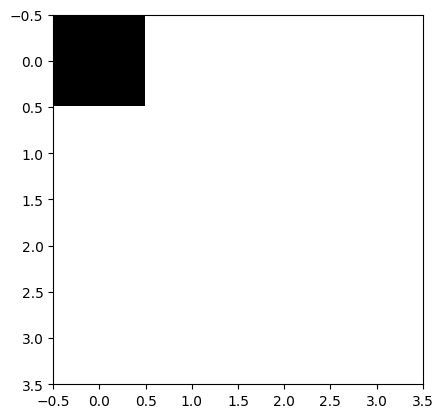

In [36]:
'''norm_test_similarity = np.zeros(test_similarity.shape)
for i in range(len(label_list)):
    norm_test_similarity[:, i] = test_similarity[:, i]/sum(test_similarity[:, i])
'''
norm_test_similarity = test_similarity
fig, ax = plt.subplots()
ax.imshow(norm_test_similarity, cmap = "gray_r")

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(1, len(labels) - 1):
    labels[i] = genre_list[i - 1]

ax.set_xticklabels(labels, rotation = 45, ha = "right")
ax.set_yticklabels(labels)

ax.set_xlabel("Actual class")
ax.set_ylabel("Predicted class")
ax.set_title("Test Classification Matrix")

plt.show()

In [70]:
def play(id):
    info = id.split('_')
    song_id = info[0]
    channel = int(info[1][-1])
    start_time = info[2]
    end_time = info[3]

    filepath = audio_dict[song_id]
    y, sr = librosa.load(filepath)

    audio_segment = y[int(float(start_time) * sr) : int(float(end_time) * sr)]

    return Audio(audio_segment, rate = sr)



In [63]:
def classified_as(id_list, pred_list, actual_list, pred_class, actual_class):
    output = []
    for i in range(len(id_list)):
        id = id_list[i]
        pred = pred_list[i]
        actual = actual_list[i]
        if (pred == pred_class):
            if (actual == actual_class):
                output.append(id)
    
    return output
            

In [69]:
label_list

['b', 'h', 'j', 'p']

In [84]:
c = classified_as(t_ids, pred_list=test_pred_classes, actual_list=test_actual, pred_class=2, actual_class=2)

In [85]:
example = random.randint(0, len(c) - 1)
print(c[example])
print(audio_dict[c[example][:4]])
play(c[example])

j022_ch1_60.0_70.0
C:/Users/anany/Cambridge/Part II Project/data/audio/large\jazz\Breezin_ Along with the Breeze.wav


# WITH PYTORCH

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

# MY CNN

In [ ]:
from cnn.activation import Tanh, Sigmoid, ReLU
from cnn.convolutional import Convolutional
from cnn.dense import Dense
from cnn.loss import MSE, MSE_prime, binary_cross_entropy, binary_cross_entropy_prime
from cnn.nn import MNIST
from cnn.reshape import Reshape

In [ ]:
from keras.utils import np_utils


In [ ]:
t1 = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
t2 = np.array([0, 1, 2, 3])

indices = random.sample(range(len(t1)), len(t1))

t1 = t1[indices]
t2 = t2[indices]

print(t1)
print(t2)

In [ ]:
def preprocess_data(x, y, limit):
    #zero_index = np.where(y == 0)[0][:limit]
    #one_index = np.where(y == 1)[0][:limit]
    

    #all_indices = np.random.permutation(np.hstack((zero_index, one_index)))

    #x, y = x[all_indices], y[all_indices]

    #x = (x.reshape(len(x), 1, 28, 28)).astype("float32") / 255

    #y = np_utils.to_categorical(y)
    #y = y.reshape(len(y), 2, 1)

    return x, y

In [ ]:
y_train.reshape(len(y_train), 2, 1).shape

In [ ]:
np.average(y_train)

In [ ]:
x_train.shape

In [ ]:
x_train = x_train.reshape(len(x_train), 1, resize_dim, resize_dim)
x_test = x_test.reshape(len(x_test), 1, resize_dim, resize_dim)



In [ ]:
y_train.shape

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_train = y_train.reshape(len(y_train), len(y_train[0]), 1)
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(len(y_test), len(y_test[0]), 1)

In [ ]:

train_indices = random.sample(range(len(x_train)), len(x_train))
test_indices = random.sample(range(len(x_test)), len(x_test))

x_train = x_train[train_indices]
y_train = y_train[train_indices]

x_test = x_test[test_indices]
y_test = y_test[test_indices]

In [ ]:
t1 = [[0, 0], [1, 1], [2, 2]]
t2 = [0, 1, 2]

zip(t1, t2)

In [ ]:
network = [
    Convolutional((1, resize_dim, resize_dim), 3, 5),
    Sigmoid(),
    Reshape((5, resize_dim - 2, resize_dim - 2), (5 * (resize_dim - 2) * (resize_dim - 2), 1)),
    Dense(5*(resize_dim - 2)*(resize_dim - 2), 100),
    Sigmoid(),
    Dense(100, 5),
    Sigmoid()
]

In [ ]:
from cnn.pooling import MaxPooling
# TODO: test forward

In [ ]:
arr = np.random.randint(20, size=(4, 4))

pool_shape = (2, 2)

output = np.zeros((int(arr.shape[0]/pool_shape[0]), int(arr.shape[1]/pool_shape[1])))

i, j = 0, 0

for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        temp = np.max(arr[i*pool_shape[0]:(i+1)*pool_shape[0], j*pool_shape[1]:j*pool_shape[1]+2])
        output[i][j] = temp#np.max(arr[i*pool_shape[0]:(i+1)*pool_shape[0]][j*pool_shape[1]:(j+1)*pool_shape[1]])

print(arr)
print(output)

In [ ]:

epochs = 10
learning_rate = 0.01

for e in range(epochs):
    error = 0

    temp = zip(x_train, y_train)
    for x, y in zip(x_train, y_train):
        output = x
        for layer in network:
            output = layer.forward(output)
        
        error += MSE(y, output)

        grad = MSE_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    
    error /= len(x_train)
    print(f"{e + 1}/{epochs}, error = {error}")


    correct = 0
    total = 0

    for x, y in zip(x_test, y_test):
        output = x
        for layer in network:
            output = layer.forward(output)
        print(f"     pred: {np.argmax(output)}, true: {np.argmax(y)}")
        total += 1
        if np.argmax(output) == np.argmax(y):
            correct += 1
    print(f"correct: {correct}, total: {total}\n\n")


correct = 0
total = 0

for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    total += 1
    if np.argmax(output) == np.argmax(y):
        correct += 1
print(f"correct: {correct}, total: {total}")

In [ ]:
audio_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/raw"
image_folderpath = "C:/Users/anany\Cambridge\Part II Project\data\images"
split_ratio = 0.75
image_type = "spectrogram"
clip_length = 10
shift_length = 500
resize_dim = 28

In [ ]:
# train_ids
# train_imgs
# train_labels

# test_ids
# test_imgs
# test_labels

In [ ]:
'''temp = train_imgs.reshape((74, 1, 28, 28, 4))

temp.shape'''

In [ ]:
'''network = [
        Convolutional(input_shape=(1, 28, 28, 4), kernel_size=3, depth=5), # output_shape=()
        Sigmoid()
    ]'''

In [ ]:
'''c = Convolutional(input_shape=(1, 28, 28, 4), kernel_size=3, depth=5), # output_shape=()
'''

In [ ]:
'''epochs = 20
learning_rate = 0.1

for e in range(epochs):
    error = 0

    temp = zip(x_train, y_train)
    for x, y in zip(x_train, y_train):
        output = x
        for layer in network:
            output = layer.forward(output)
        
        error += binary_cross_entropy(y, output)

        grad = binary_cross_entropy_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    
    error /= len(x_train)
    print(f"{e + 1}/{epochs}, error = {error}")'''

In [ ]:
'''MNIST()'''

In [ ]:
'''arr = np.array([[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]], [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]])
# 2 3 4

new_arr = np.moveaxis(arr, 2, 0)
# 4 3 2

new_arr[:3]'''

In [ ]:
'''arr'''

In [ ]:
'''arr = train_imgs[0]

new_arr = np.moveaxis(arr, -1, 0)

new_arr'''

In [ ]:
MNIST()

# ANALYSIS

PLOTS

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = model_gen.predict(generate_data(test_set, mode="predict"))

compare = np.zeros((len(label_list), len(label_list)))
y_pred_classes = y_pred_probs.argmax(axis=1)
actual = y_test.T[0]

for i in range(len(y_pred_classes)):
    compare[y_pred_classes[i]][actual[i]] += 1

'''for i in range(len(label_list)):
    compare[:, i] = compare[:, i]/sum(compare[:, i])'''

fig, ax = plt.subplots()
ax.imshow(compare, cmap = "gray_r")

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(1, len(labels) - 1):
    labels[i] = genre_list[i - 1]

ax.set_xticklabels(labels, rotation = 45, ha = "right")
ax.set_yticklabels(labels)

ax.set_xlabel("Actual class")
ax.set_ylabel("Predicted class")
ax.set_title("Clip Classification Matrix")

plt.show()


In [ ]:
len(t1)

In [ ]:
y_pred_probs.shape

In [ ]:
temp = generate_data(test_set, mode="predict_ids_labels")
t1, t2 = next(temp)

In [ ]:
t1

In [ ]:
test_labels

In [ ]:
# similarity matrix method

In [75]:
from IPython.display import Audio
import librosa

In [ ]:
def play(id):
    info = id.split('_')
    song_id = info[0]
    channel = int(info[1][-1])
    start_time = info[2]
    end_time = info[3]

    filepath = audio_dict[song_id]
    y, sr = librosa.load(filepath)

    audio_segment = y[int(float(start_time) * sr) : int(float(end_time) * sr)]

    return Audio(audio_segment, rate = sr)



In [ ]:
clip_vote_dict = {}
song_clip_dict = {}

In [ ]:
for id in list(audio_dict.keys()):
    # np.where(np.char.find(test_ids, 'r009') >= 0) ids where 'r009' appears in the string
    if id in test_set:
        song_clip_dict[id] = test_ids[np.where(np.char.find(test_ids, id) >= 0)]
    else:
        #song_clip_dict[id] = train_ids[np.where(np.char.find(train_ids, id) >= 0)]
        pass

In [ ]:
y_pred_class_onehot = np.eye(len(genre_id.keys()))[y_pred_classes]

In [ ]:
for i in range(len(test_ids)):
    id = test_ids[i]
    if id not in clip_vote_dict.keys():
        clip_vote_dict[id] = np.zeros(len(genre_id.keys()))
    clip_vote_dict[id] = clip_vote_dict[id] + y_pred_class_onehot[i]
    

In [ ]:
song_vote_dict = {}

In [ ]:
for song_id in test_set:
    song_vote_dict[song_id] = np.zeros(len(genre_id.keys()))
    for clip_id in song_clip_dict[song_id]:
        song_vote_dict[song_id] = song_vote_dict[song_id] + clip_vote_dict[clip_id]

In [ ]:
for id in song_vote_dict:
    print("id: {0} pred {1} actual {2}   votes {3}".format(id, label_list[(np.argmax(song_vote_dict[id]))], id[0], song_vote_dict[id]))

In [ ]:
audio_dict['h004']

In [ ]:
song_similarity = np.zeros((len(label_list), len(label_list)))

for id in song_vote_dict:
    prediction = np.argmax(song_vote_dict[id])
    actual = label_list.index(id[0])
    song_similarity[prediction][actual] += 1

for i in range(len(label_list)):
    if sum(song_similarity[:, i]) >= 0:
        song_similarity[:, i] = song_similarity[:, i]/sum(song_similarity[:, i])

In [ ]:
song_similarity

In [ ]:
fig, ax = plt.subplots()
ax.imshow(song_similarity, cmap = "gray_r")

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(1, len(labels) - 1):
    labels[i] = genre_list[i - 1]

ax.set_xticklabels(labels, rotation = 45, ha = "right")
ax.set_yticklabels(labels)

ax.set_xlabel("Actual class")
ax.set_ylabel("Predicted class")
ax.set_title("Song Classification Matrix")

In [ ]:
'''make a dictionary of songs to song samples
make a dictionary of song samples to probabilities
'''

In [ ]:
def song_classifications(labels, prob_array):
    # TODO: get probability distributions for a song
    pass
    # label list genre list whatever whatever
    # do the argmax thing
    # output probdis = numpy array of size of genres
    # for each:
        # vote
    # divide by number of samples - maybe dont do this so you can add these for several runss


# agrmax output of this to get 

In [ ]:
'''def something(id_list, probabilities):
    for each song:
        # get array ids of samples in song
        song_classificatio'''